<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/part_6_customise_state_human_in_the_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Quick Start***
In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

Answer common questions by searching the web
Maintain conversation state across calls
Route complex queries to a human for review
Use custom state to control its behavior
Rewind and explore alternative conversation paths
We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

Setup
First, install the required packages:

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community

In [3]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('memory-enabled-agent')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('GOOGLE_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get("Tavily_Api_Key")

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)
llm.invoke("greeting me")

AIMessage(content='Hello there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-320e791f-44f4-4f73-b1f1-883fb91ecb7d-0', usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults # Import the necessary class

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("what is current weather in karachi?")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1732943170, 'localtime': '2024-11-30 10:06'}, 'current': {'last_updated_epoch': 1732942800, 'last_updated': '2024-11-30 10:00', 'temp_c': 24.3, 'temp_f': 75.7, 'is_day': 1, 'condition': {'text': 'Overcast', 'icon': '//cdn.weatherapi.com/weather/64x64/day/122.png', 'code': 1009}, 'wind_mph': 6.5, 'wind_kph': 10.4, 'wind_degree': 54, 'wind_dir': 'NE', 'pressure_mb': 1017.0, 'pressure_in': 30.03, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 57, 'cloud': 0, 'feelslike_c': 24.4, 'feelslike_f': 75.9, 'windchill_c': 27.5, 'windchill_f': 81.5, 'heatindex_c': 26.6, 'heatindex_f': 80.0, 'dewpoint_c': 9.1, 'dewpoint_f': 48.3, 'vis_km': 2.5, 'vis_miles': 1.0, 'uv': 2.3, 'gust_mph': 8.1, 'gust_kph': 13.1}}"},
 {'url': 'https://tgftp.nws.noaa.gov/weather/current/OPKC.html',
  'content': 'Current W

In [11]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END  # Ensure END is imported
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, ToolMessage
from IPython.display import Image, display

# Initialize MemorySaver
memory = MemorySaver()

# Define the State class with messages and ask_human flag
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool  # This flag is new
    # ya first schema tool k use k lya bnaya ha


In [12]:
# Define the RequestAssistance model using Pydantic
class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions."""
    request: str
    # ya schema human k tool k lya bnaya ha

In [13]:


# Bind the LLM to tools and the RequestAssistance model
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

In [30]:
response = llm_with_tools.invoke("i need some tips about loss weight plz connect me agent")
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (ddb973fa-bc76-4223-96dc-69388777f669)
 Call ID: ddb973fa-bc76-4223-96dc-69388777f669
  Args:
    request: I need some tips about weight loss.  Connect me with an agent.


In [37]:


# Define the chatbot function
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

# Initialize the StateGraph
graph_builder = StateGraph(State)
# is node ma phla llm ko call ki msg pas kro or human ki need ni ha i mean false or ager
# human ki need ha true kro or wo query human ko pass krdo phr ek statgraph bnao

In [38]:
# Add nodes to the graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))
# iska parameter ma ek tool or human k tool true hona k lya use kya ha

In [39]:
# Define the create_response function
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,  # Human ka response yahan content mein set hota hai
        tool_call_id=ai_message.tool_calls[0]["id"],  # AI message se related tool call ID set hoti hai
    )

    # this is helper function
    # get resonse by human and return and convert in tool msg

# Define the human_node function
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Add placeholder message if no response from human
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        "messages": new_messages,
        "ask_human": False,  # Reset ask_human flag
    }
# Human node ka purpose hai human ke response ka wait karna. Agar human reply nahi karta,
#  toh chatbot "No response from human." message khud hi add kar deta hai aur ask_human flag
# ko False set karta hai, jo batata hai ke ab human ki zaroorat nahi hai aur chatbot aage
# continue kar sakta hai.
# Add the human node to the graph
graph_builder.add_node("human", human_node)

In [41]:
# Define the select_next_node function
def select_next_node(state: State):
  # ager true ha to human ko query bhjo
    if state["ask_human"]:
        return "human"
    return tools_condition(state)
    # werna tool  k pas bhjo
graph_builder.add_edge(START, "chatbot")

# Add conditional edges to the graph
graph_builder.add_conditional_edges("chatbot",select_next_node,{"human": "human", "tools": "tools", "END": END})
# chatbot na select krna ha k human k pas tool k pas ya phr end krna ha query ko

In [42]:
# Add other necessary edges
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")


# Compile the graph without end_node (removed based on error)
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"]
)


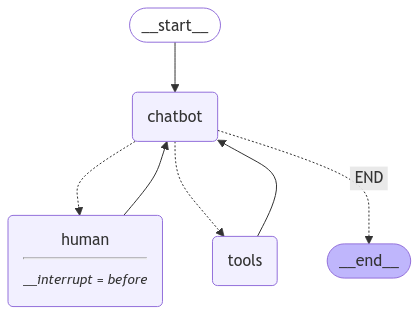

In [43]:
# Display the graph (optional, requires additional dependencies)
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [44]:
from langchain.schema.messages import ToolMessage, HumanMessage, AIMessage  # Import from langchain.schema.messages


In [45]:
config1 = {"configurable": {"thread_id": "1"}} # Changed config1 to a dictionary with the correct structure
message = graph.invoke({"messages":[HumanMessage(content = "I need some expert guidance for building this AI agent. Could you request assistance for me?")]}, config1)
for m in message["messages"]:
  m.pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (61d1f1a9-0053-4e10-8e9f-a3794a4ceb69)
 Call ID: 61d1f1a9-0053-4e10-8e9f-a3794a4ceb69
  Args:
    request: I need some expert guidance for building this AI agent.


In [46]:
snapshot=graph.get_state(config1)
snapshot.next


('human',)

In [47]:
ai_message = graph.get_state(config1).values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)


In [48]:
# Aik snapshot ya response ko `ai_message` mein store karna

# Phir `ai_message` ko create_response function mein use karein
tool_message = create_response(human_response, ai_message)
graph.update_state(config1, {"messages": [tool_message]})



{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efaed8c-e7fe-6c86-8002-f7c6af07a418'}}

In [52]:
for m in graph.get_state(config1).values["messages"]:
  m.pretty_print()



================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (61d1f1a9-0053-4e10-8e9f-a3794a4ceb69)
 Call ID: 61d1f1a9-0053-4e10-8e9f-a3794a4ceb69
  Args:
    request: I need some expert guidance for building this AI agent.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
